In [6]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob, os

In [7]:
def findFiles(path):
    return glob.glob(path) #return all files paths that match a specific pattern

print(findFiles('data/names/*.txt'))


['data/names/Italian.txt', 'data/names/Irish.txt', 'data/names/Russian.txt', 'data/names/Portuguese.txt', 'data/names/Arabic.txt', 'data/names/Czech.txt', 'data/names/Scottish.txt', 'data/names/Vietnamese.txt', 'data/names/Chinese.txt', 'data/names/Korean.txt', 'data/names/Polish.txt', 'data/names/Japanese.txt', 'data/names/Spanish.txt', 'data/names/English.txt', 'data/names/German.txt', 'data/names/Dutch.txt', 'data/names/Greek.txt', 'data/names/French.txt']


In [8]:
import unicodedata, string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )
print(unicodeToAscii('Trương Minh Hồng'))

Truong Minh Hong


In [9]:
category_lines = dict()
all_categories = list()

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [10]:
print(all_categories)
print(category_lines['Vietnamese'][:5])

['Italian', 'Irish', 'Russian', 'Portuguese', 'Arabic', 'Czech', 'Scottish', 'Vietnamese', 'Chinese', 'Korean', 'Polish', 'Japanese', 'Spanish', 'English', 'German', 'Dutch', 'Greek', 'French']
['Nguyen', 'Tron', 'Le', 'Pham', 'Huynh']


In [11]:
%pip install torch

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 977.5 kB/s eta 0:00:0000:0100:08
Note: you may need to restart the kernel to use updated packages.


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim

In [12]:
def letterToIndex(letter):
    return all_letters.find(letter)

def letterToTensor(letter):
    tensor = torch.zeros(size = (1, n_letters))
    tensor[0][letterToIndex(letter)] = 1
    return tensor

def lineToTensor(line):
    tensor = torch.zeros(size = (len(line), 1, n_letters))  #1 for batch
    for index, letter in enumerate(line):
        tensor[index][0][letterToIndex(letter)] = 1
    return tensor

In [109]:
class RNN(nn.Module):
    def __init__(self, inputSize, hiddenSize, outputSize):
        super(RNN, self).__init__()
        self.hiddenSize = hiddenSize
        self.i2h = nn.Linear(inputSize+hiddenSize, hiddenSize)
        self.i2o = nn.Linear(inputSize+hiddenSize, outputSize)
        self.softmax = nn.Softmax(dim = 1)
    def initHidden(self):
        return torch.zeros(size = (1, self.hiddenSize), dtype=torch.long)
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden =  self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

In [110]:
n_hidden = 128
model = RNN(n_letters, n_hidden, n_categories)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=model.parameters(), lr=0.1, momentum=0.9)

In [105]:
model.eval()

RNN(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (i2o): Linear(in_features=185, out_features=18, bias=True)
  (softmax): Softmax(dim=1)
)

In [107]:
def train(input, target):
    hidden = model.initHidden()
    
    model.zero_grad()
    for i in range(input.size()[0]):
        output, hidden = model(input[i], hidden)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    
    return output, loss.item()
    

In [70]:
#category lines --> dictionary (languages: list of words)
#all_categories --> list of languages
import random

def randomTraining():
    #Get random language
    langIndex = random.randint(0, len(all_categories) - 1)
    category = all_categories[langIndex]

    #convert target language to one-hot
    targetTensor = torch.zeros(size = (1, len(all_categories)))
    targetTensor[0][langIndex] = 1

    #Get random word from that language
    wordIndex = random.randint(0, len(category_lines[category]) - 1)
    word = category_lines[category][wordIndex]
    inputTensor = lineToTensor(word)
    return word, inputTensor, category, targetTensor

In [43]:
for i in range(5):
    word, inputTensor, category, targetTensor = randomTraining()
    print(f'category: {category}, word: {word}')
    print(f'inputTensor: {inputTensor.shape}')
    print(f'targetTensor: {targetTensor.shape}')
    print('*'*20)

category: Spanish, word: Villanueva
inputTensor: torch.Size([10, 1, 57])
targetTensor: torch.Size([1, 18])
********************
category: Dutch, word: Kappel
inputTensor: torch.Size([6, 1, 57])
targetTensor: torch.Size([1, 18])
********************
category: Korean, word: San
inputTensor: torch.Size([3, 1, 57])
targetTensor: torch.Size([1, 18])
********************
category: Vietnamese, word: Nghiem
inputTensor: torch.Size([6, 1, 57])
targetTensor: torch.Size([1, 18])
********************
category: Russian, word: Halyapin
inputTensor: torch.Size([8, 1, 57])
targetTensor: torch.Size([1, 18])
********************


In [113]:
import time

n_iters = 10000
Loss = list()
currentLoss = 0
for iter in range(1, n_iters + 1):
    start = time.time()
    word, inputTensor, category, targetTensor = randomTraining()
    outputTensor, loss = train(inputTensor, targetTensor)
    currentLoss += loss
    Loss.append(currentLoss)
    '''if iter % 5000 == 0:
        print(f"iter {iter}/{n_iters}, loss = {currentLoss/5000} ({time.time()- start})")
        Loss.append(currentLoss/5000)
        currentLoss = 0
        start = time.time()'''

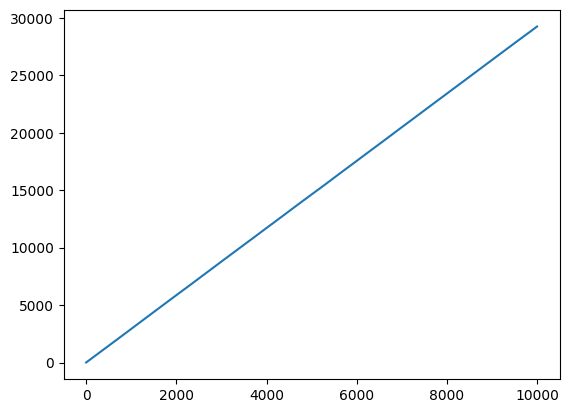

In [114]:
import matplotlib.pyplot as plt
plt.plot(Loss)
plt.show()